# Hour data cleansing - version 1

The purpose of this script is to cleanse recorded hours data so that it can be used to reliably record changes in asset usage 
over time as well as making predictions of asset usage at furture dates.

The data is collected manually by engineers when visiting assets on site. This process is prone to errors and false readings, making it unreliable for prediction. 

This process needs to be repeatable as it is intended to be applied for each asset within a fleet of several thousand pieces of equipment. 

This script is intended to test the code, however the final code will be implemented within a query in Power BI. 



###### Load and view raw data

In [1]:
###Import libraries###

import csv
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt

In [2]:
###Test dataset###

#EquipID: the unique identifier for each asset
#x: Date reading stored as float
#y: Equipment clock hours on each date as float

EquipID = [619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 619999, 611693, 611693, 611693, 611693, 611693, 611693, 611693, 611693, 611693, 611693, 611693,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340,612340]
x = [43480.0, 43481.0, 43520.0, 43585.0, 43593.0, 43803.0, 43850.0, 43907.0, 43978.0, 44026.0, 44048.0, 44076.0, 44167.0, 44361.0, 44481.0, 44502.0, 44613.0, 44622.0, 44707.0, 43593.0, 43745.0, 43772.0, 43970.0, 44069.0, 44167.0, 44370.0, 44480.0, 44598.0, 44662.0, 44707.0,43507,43562,43570,43579,43696,43745,43759,43789,43807,43809,43810,43813,43821,43900,43905,43913,43970,43977,43978,44003,44006,44011,44012,44034,44075,44079,44087,44091,44122,44175,44244,44321,44334,44366,44384,44392,44402,44478,44479,44509,44517,44525,44528,44565,44570,44571,44607,44615,44639,44649,44654,44703]
y = [6696.0, 6700.0, 6802.0, 7003.0, 7017.0, 6933.0, 7134.0, 7137.0, 7137.0, 7153.0, 7626.0, 7186.0, 7263.0, 7390.0, 7503.0, 7524.0, 7636.0, 7659.0, 7767.0, 30.0, 528.0, 540.0, 1063.0, 1539.0, 1464.0, 2391.0, 2765.0, 2975.0, 3130.0, 3231.0,6326,6559,6568,6612,7268,7548,7577,7730,7730,7732,7732,7737,7790,7790,8116,5149,8406,8427,8427,8502,8528,8528,8540,8604,8604,8847,8887,8887,9059,9389,9720,1002,1006,1006,1024,1026,1029,1072,1084,1094,1094,1098,1098,1117,1120,11190,1133,1135,1145,1150,1153,1174]

In [3]:
###Create dataframe from test data###

df = pd.DataFrame({'EquipID': EquipID,

                   'x': x,

                   'y': y}, columns=['EquipID', 'x', 'y'])
df

,EquipID,x,y
0,619999,43480.0,6696.0
1,619999,43481.0,6700.0
2,619999,43520.0,6802.0
3,619999,43585.0,7003.0
4,619999,43593.0,7017.0
...,...,...,...
77,612340,44615.0,1135.0
78,612340,44639.0,1145.0
79,612340,44649.0,1150.0
80,612340,44654.0,1153.0


611693


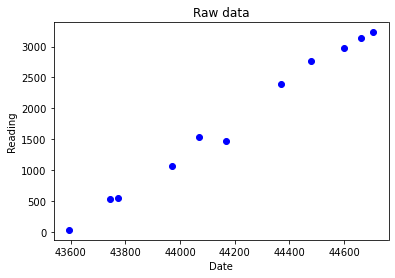

612340


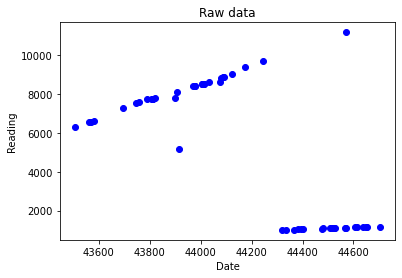

619999


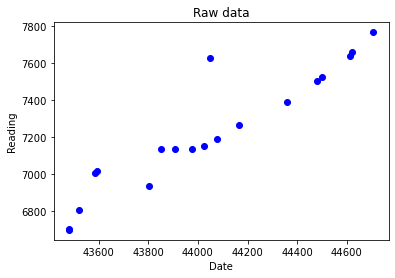

In [4]:
df_grouped = df.groupby('EquipID')
for EquipID, group in df_grouped:
    print(EquipID)
    x_plot = group['x']
    y_plot = group['y']
    plt.scatter(x_plot, y_plot, c = 'blue')
    plt.title('Raw data')
    plt.xlabel('Date')
    plt.ylabel('Reading')
    plt.show()

###### Initial filtering

In [5]:
###Initial filters### 
#1) Recognise whether the meter has been reset and assign new trend. 
#2) If value is lower than previous value then remove it.
#3) If values are taken within 14 days of each other then remove.

res_trend = pd.DataFrame()
res = pd.DataFrame()

#Run for each EquipID
df_grouped = df.groupby('EquipID')
for EquipID, group in df_grouped:
#Has the meter been reset? If so add set FiltTrend + 1    
    filt_trend = group.assign(FiltTrend=((group['y']<group['y'].shift(periods=1))&(group['y'].shift(periods=-1)<group['y'].shift(periods=2))).cumsum().astype(int))
    res_trend = pd.concat([res_trend, filt_trend])
df = res_trend

#Concatonate EquipID and FiltTrend
df['FiltTrend'] = df['EquipID'].apply(str)+"_"+df['FiltTrend'].apply(str)

#Run for each Trend
df_grouped = df.groupby(['FiltTrend'])
for FiltTrend, group in df_grouped:
#Remove values lower than previous line  
    filt_lower = group.assign(FiltLower=((pd.isna(group['x'].shift())) | (group['y'] > group['y'].shift())).astype(int))
#    filt_lower.drop(filt_lower.loc[filt_lower['FiltLower']==0].index, inplace=True)
#    filt_lower=filt_lower.drop(columns=['FiltLower'])

    #Remove values too close together in time   
    filt_time = filt_lower.assign(FiltTime=((pd.isna(filt_lower['x'].shift())) | ((filt_lower['x'] - filt_lower['x'].shift())>2)).astype(int))
#    filt_time.drop(filt_time.loc[filt_time['FiltTime']==0].index, inplace=True)
#    
    res = pd.concat([res, filt_time], ignore_index=True)
    df = res.assign(Filter=(res['FiltTime']*res['FiltLower']))
    df = df.drop(columns=['FiltTime'])
    df = df.drop(columns=['FiltLower'])
df

,EquipID,x,y,FiltTrend,Filter
0,611693,43593.0,30.0,611693_0,1
1,611693,43745.0,528.0,611693_0,1
2,611693,43772.0,540.0,611693_0,1
3,611693,43970.0,1063.0,611693_0,1
4,611693,44069.0,1539.0,611693_0,1
...,...,...,...,...,...
77,619999,44481.0,7503.0,619999_0,1
78,619999,44502.0,7524.0,619999_0,1
79,619999,44613.0,7636.0,619999_0,1
80,619999,44622.0,7659.0,619999_0,1


611693


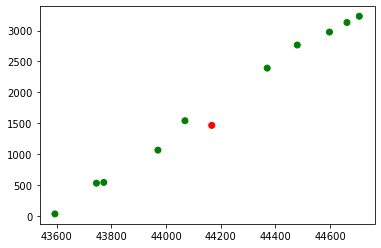

612340


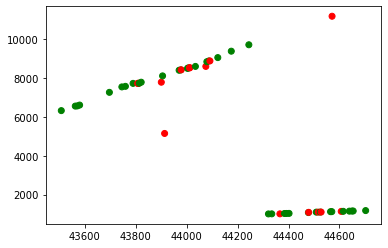

619999


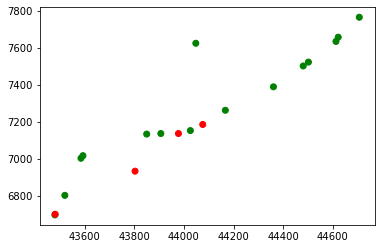

In [6]:
df_grouped = df.groupby('EquipID')
for EquipID, group in df_grouped:
    print(EquipID)
    x_plot = group['x']
    y_plot = group['y']
    filt_plot = group['Filter']
    colors = {0:'r',1:'g'}
    plt.scatter(x_plot, y_plot,c=filt_plot.map(colors))
    plt.show()

In [7]:
df.drop(df.loc[df['Filter']==0].index, inplace=True)
df

,EquipID,x,y,FiltTrend,Filter
0,611693,43593.0,30.0,611693_0,1
1,611693,43745.0,528.0,611693_0,1
2,611693,43772.0,540.0,611693_0,1
3,611693,43970.0,1063.0,611693_0,1
4,611693,44069.0,1539.0,611693_0,1
...,...,...,...,...,...
77,619999,44481.0,7503.0,619999_0,1
78,619999,44502.0,7524.0,619999_0,1
79,619999,44613.0,7636.0,619999_0,1
80,619999,44622.0,7659.0,619999_0,1


###### Second filter using regression, standard deviation and correlation

A second filter is then applied to remove values which fall outside of upper and lower bounds calculated using standard deviation. 

A 4 term polynomial is first fitted to the data, which acts as a moving mean value. Correlation and standard deviation are then calculated using the polynomial as a mean value. Standard deviation is then used to calculate upper and lower bound of reliable data. 

A non-linear equation was used to limit the number of standard deviations of data within the sample as correlation gets lower.
Equation used = std_dev*((1.8531*(max(corr)^2))+0.5287*max(corr)+1.0143)

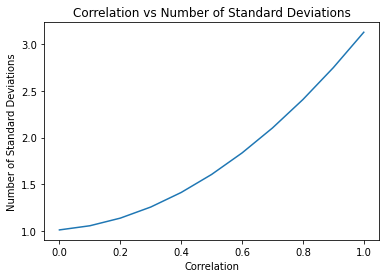

In [8]:
#For the plot below it is assumed that the value of standard deviation is 1. 

corr = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
std_dev = [1.0143, 1.0587, 1.1402, 1.2587, 1.4143, 1.6069, 1.8366, 2.1034, 2.4072, 2.7481, 3.1261]

plt.plot(corr,std_dev)
plt.title('Correlation vs Number of Standard Deviations')
plt.xlabel('Correlation')
plt.ylabel('Number of Standard Deviations')
plt.show()

The following function caculates regression standard deviation and correlation and filters the data. 

In [10]:
###Create function to find polynomial and linear regression terms from x y. Then filter readings which are outside a threshold based on standard deviation.### 
def standard_dev_filter():
#Create empty arrays
    std_array = np.empty([0, 0])
    cc_array = np.empty([0, 0])
    upperlimit_array = np.empty([0, 0])
    lowerlimit_array = np.empty([0, 0])
    poly_array = np.empty([0, 0])
    gradient_array = np.empty([0, 0])
    intercept_array = np.empty([0, 0])
    a_array = np.empty([0, 0])
    b_array = np.empty([0, 0])
    c_array = np.empty([0, 0])
    d_array = np.empty([0, 0])
    
    #Calculate for each EquipID and Trend
    df_grouped = df.groupby(['EquipID','FiltTrend'])
    for FiltTrend, group in df_grouped:
        x_array = np.array(group[['x']])
        y_array = np.array(group[['y']])      
        x_array2 = x_array.ravel()
        y_array2 = y_array.ravel()

        #Calculate intercept and gradient for linear regression 
        model = LinearRegression().fit(x_array,y_array)
        model.fit(x_array,y_array)        
        gradient = x_array*0+float(model.coef_)
        intercept = x_array*0+float(model.intercept_)
    
        #fit 4 term polynomial regression to x y
        fit = np.polyfit(x_array2, y_array2, 3)
        a = fit[0]
        b = fit[1]
        c = fit[2]
        d = fit[3]

        fit_equation = a * np.power(x_array2, 3) + b *np.power(x_array2, 2) + c * x_array2 + d

        #Calculate standard deviation using polynomial as mean
        count = len(x_array)
        std_dev = x_array2*0+(math.sqrt((sum(np.power(y_array2 - fit_equation,2)))/count))
    
        #Calculate correlation coefficient
        C1 = x_array - np.mean(x_array)
        C2 = y_array - np.mean(y_array)
        C3 = np.power(x_array - np.mean(x_array),2)
        C4 = np.power(y_array - np.mean(y_array),2)
        correlation = x_array*0+(sum(C1 * C2) / math.sqrt(sum(C3)*sum(C4)))

        #Create upper and lower bounds for reliable data. When correlation is poor the number of standard deviations is reduced.
        lowerlimit = fit_equation - (std_dev*((1.8531*(max(correlation)*max(correlation)))+0.5287*max(correlation)+1.0143))
        upperlimit = fit_equation + (std_dev*((1.8531*(max(correlation)*max(correlation)))+0.5287*max(correlation)+1.0143))
                
        #Append calculated values to arrays
        a_array = np.append(a_array, x_array*0+a)
        b_array = np.append(b_array, x_array*0+b)
        c_array = np.append(c_array, x_array*0+c)
        d_array = np.append(d_array, x_array*0+d)             
        gradient_array = np.append(gradient_array, gradient)
        intercept_array = np.append(intercept_array, intercept) 
        std_array = np.append(std_array, std_dev)
        cc_array = np.append(cc_array,correlation)
        lowerlimit_array = np.append(lowerlimit_array, lowerlimit)
        upperlimit_array = np.append(upperlimit_array, upperlimit)
        poly_array = np.append(poly_array, fit_equation)
    
    #Add arrays as columns in dataframe
    df["StdDev"] = std_array.tolist()
    df["PolyMean"]=poly_array.tolist()
    df["CC"] = cc_array.tolist()
    df["Lower Limit"] = lowerlimit_array.tolist()
    df["Upper Limit"] = upperlimit_array.tolist()
    df["Gradient"] = gradient_array.tolist()
    df["Intercept"] = intercept_array.tolist()
    df["a"] = a_array.tolist()
    df["b"] = b_array.tolist()
    df["c"] = c_array.tolist()
    df["d"] = d_array.tolist()
    
standard_dev_filter()
df    

,EquipID,x,y,FiltTrend,Filter,StdDev,PolyMean,CC,Lower Limit,Upper Limit,Gradient,Intercept,a,b,c,d
0,611693,43593.0,30.0,611693_0,1,45.964429,51.633291,0.998229,-104.122080,207.388663,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
1,611693,43745.0,528.0,611693_0,1,45.964429,464.759005,0.998229,309.003634,620.514377,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
2,611693,43772.0,540.0,611693_0,1,45.964429,543.958314,0.998229,388.202943,699.713686,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
3,611693,43970.0,1063.0,611693_0,1,45.964429,1159.112746,0.998229,1003.357374,1314.868117,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
4,611693,44069.0,1539.0,611693_0,1,45.964429,1478.451914,0.998229,1322.696543,1634.207286,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,619999,44481.0,7503.0,619999_0,1,103.804023,7496.453708,0.927964,7174.593744,7818.313673,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08
78,619999,44502.0,7524.0,619999_0,1,103.804023,7514.733127,0.927964,7192.873162,7836.593091,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08
79,619999,44613.0,7636.0,619999_0,1,103.804023,7636.048194,0.927964,7314.188229,7957.908158,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08
80,619999,44622.0,7659.0,619999_0,1,103.804023,7647.915246,0.927964,7326.055282,7969.775211,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08


###### Outputs

Two dateframes are output.

The first one containing intercept and gradient from linear regression and terms from polynomial regression. 

In [11]:
###Create second dataframe which only contains polynomial and linear regression terms for each EquipID/Trend

df_regress_terms = df.drop_duplicates(['FiltTrend'], keep='first')
df_regress_terms = df_regress_terms.drop(columns=['x','y','PolyMean','CC','Lower Limit','Upper Limit'])
df_regress_terms

,EquipID,FiltTrend,Filter,StdDev,Gradient,Intercept,a,b,c,d
0,611693,611693_0,1,45.964429,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07
11,612340,612340_0,1,38.966583,4.444833,-187021.898747,0.000006,-0.814283,35739.280983,-5.229204e+08
42,612340,612340_1,1,3.090658,0.468653,-19772.892380,-0.000002,0.254526,-11323.684815,1.679208e+08
63,619999,619999_0,1,103.804023,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08


The second outputted dataframe contains the final filtered data. 

In [12]:
#Remove rows where the value of y is outside of the upper and lower limits of reliable data

df = df.assign(FiltLimits=((df['y'] > df['Lower Limit']) & (df['y'] < df['Upper Limit'])).astype(int))
df['Filter'] = df['Filter']*df['FiltLimits']
#df.drop(df.loc[df['FiltLimits']==0].index, inplace=True)
df

,EquipID,x,y,FiltTrend,Filter,StdDev,PolyMean,CC,Lower Limit,Upper Limit,Gradient,Intercept,a,b,c,d,FiltLimits
0,611693,43593.0,30.0,611693_0,1,45.964429,51.633291,0.998229,-104.122080,207.388663,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07,1
1,611693,43745.0,528.0,611693_0,1,45.964429,464.759005,0.998229,309.003634,620.514377,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07,1
2,611693,43772.0,540.0,611693_0,1,45.964429,543.958314,0.998229,388.202943,699.713686,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07,1
3,611693,43970.0,1063.0,611693_0,1,45.964429,1159.112746,0.998229,1003.357374,1314.868117,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07,1
4,611693,44069.0,1539.0,611693_0,1,45.964429,1478.451914,0.998229,1322.696543,1634.207286,2.923747,-127400.485837,-0.000001,0.151426,-6667.589838,9.781645e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,619999,44481.0,7503.0,619999_0,1,103.804023,7496.453708,0.927964,7174.593744,7818.313673,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08,1
78,619999,44502.0,7524.0,619999_0,1,103.804023,7514.733127,0.927964,7192.873162,7836.593091,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08,1
79,619999,44613.0,7636.0,619999_0,1,103.804023,7636.048194,0.927964,7314.188229,7957.908158,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08,1
80,619999,44622.0,7659.0,619999_0,1,103.804023,7647.915246,0.927964,7326.055282,7969.775211,0.705211,-23810.689914,0.000001,-0.182903,8070.985462,-1.187137e+08,1


The final filtered dataset with points ouside of the standard deviation filter coloured in red to be removed.

611693


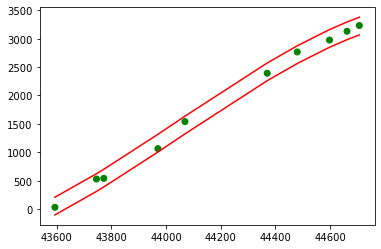

612340


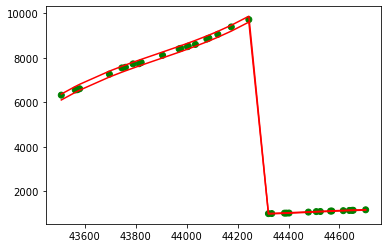

619999


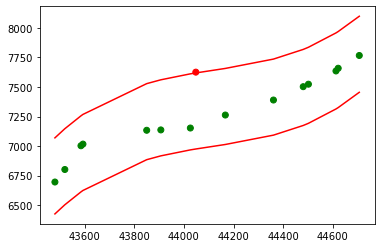

In [13]:
df_grouped = df.groupby('EquipID')
for EquipID, group in df_grouped:
    print(EquipID)
    x_plot = group['x']
    y_plot = group['y']
    upper_plot = group['Upper Limit']
    lower_plot = group["Lower Limit"]
    filt_plot = group['Filter']
    colors = {0:'r',1:'g'}
    plt.scatter(x_plot, y_plot,c=filt_plot.map(colors))
    plt.plot(x_plot, upper_plot,color='red')
    plt.plot(x_plot, lower_plot,color='red')
    plt.show()